In [3]:
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt

In [4]:
import pandas as pd

# Read the Excel file
df = pd.read_excel("lottery_data.xlsx")

# Filter the dataframe to only include rows where reward_type is 5
df_filtered = df[df['reward_type'] == 5]

# Extract the last 2 digits from each number in the "Number" column
# lottery_list = df['number'].map(lambda x: str(x)[-2:]).tolist()
lottery_list = df_filtered['number'].map(lambda x: str(x)[-2:]).tolist()

print(lottery_list[:10])

['95', '06', '04', '24', '15', '92', '78', '43', '48', '51']


In [5]:
from collections import Counter

# Filter out non-numeric values from the lottery_list
filtered_lottery_list = [x for x in lottery_list if x.isdigit()]

# Convert the filtered lottery_list to integers
lottery_numbers = list(map(int, filtered_lottery_list))

# Count the frequency of each number
frequency_count = Counter(lottery_numbers)

# Convert the frequency count to a DataFrame
frequency_df = pd.DataFrame(list(frequency_count.items()), columns=['Number', 'Frequency'])

# Sort the DataFrame by Number
frequency_df = frequency_df.sort_values(by='Number').reset_index(drop=True)

frequency_df

,Number,Frequency
0,0,443
1,1,434
2,2,422
3,3,412
4,4,445
...,...,...
95,95,387
96,96,442
97,97,443
98,98,395


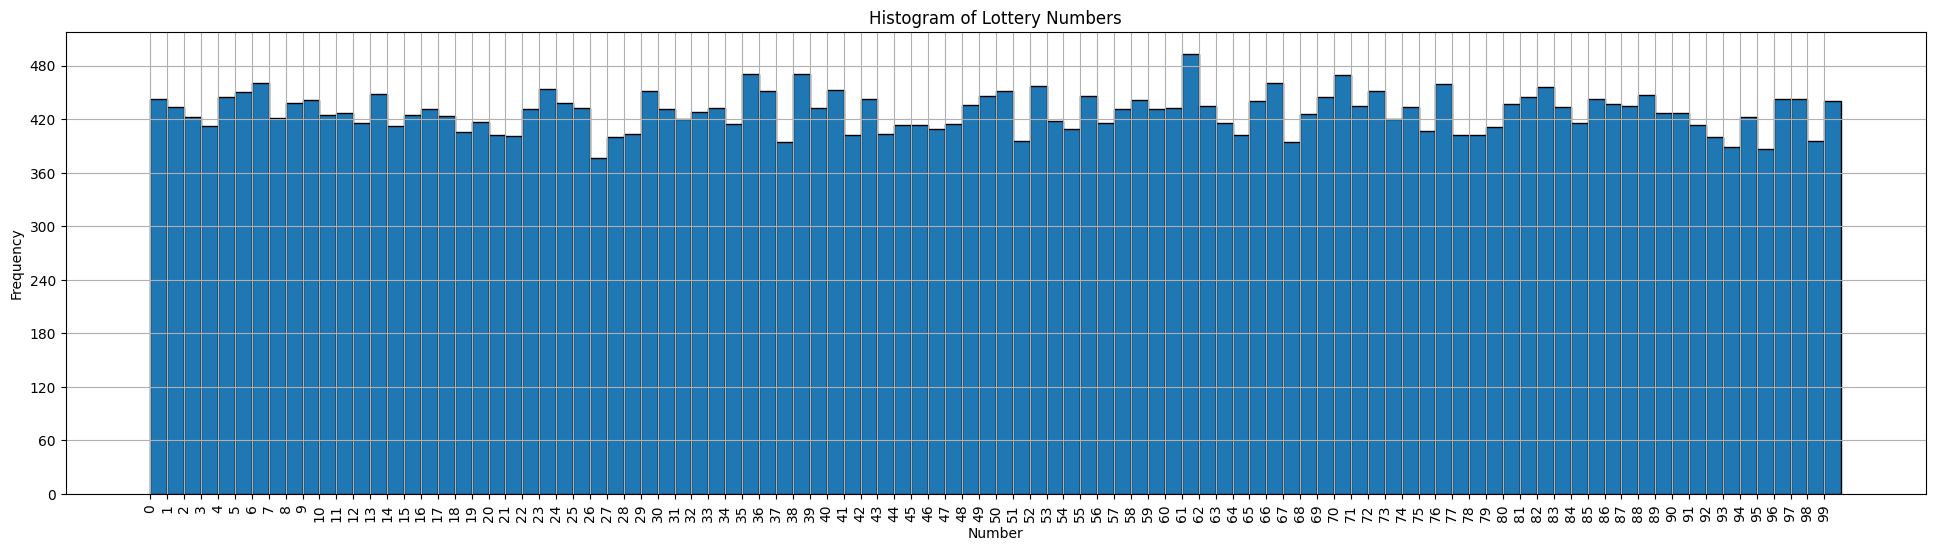

In [6]:
# First plot
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

# Convert the filtered lottery_list to integers
lottery_numbers = list(map(int, filtered_lottery_list))

# Plot the histogram with a larger figure size
plt.figure(figsize=(24, 6))
plt.hist(lottery_numbers, bins=range(101), edgecolor='black')
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.title('Histogram of Lottery Numbers')
plt.xticks(range(0, 100, 5))  # Set x-ticks at intervals of 5
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)

# Display the numbers on the x-axis with rotation to avoid overlap
plt.xticks(range(0, 100, 1), rotation=90)

plt.show()

# # Second plot (switch x-axis and y-axis)
# plt.figure(figsize=(12, 24))
# plt.barh(frequency_df['Number'], frequency_df['Frequency'], edgecolor='black')
# plt.ylabel('Number')
# plt.xlabel('Frequency')
# plt.title('Horizontal Bar Plot of Lottery Numbers')
# plt.yticks(range(0, 100, 5))  # Set y-ticks at intervals of 5
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.grid(True)

# plt.show()

## Check Uniformly

### Standard deviation

In [7]:
import numpy as np

# Calculate the frequency of each number
frequency, bins = np.histogram(lottery_numbers, bins=range(101))

# Calculate mean and standard deviation
mean_frequency = np.mean(frequency)
std_frequency = np.std(frequency)
cv = std_frequency / mean_frequency

print(f"Mean Frequency: {mean_frequency}")
print(f"Standard Deviation of Frequency: {std_frequency}")
print(f"Coefficient of Variation: {cv}")

Mean Frequency: 428.24
Standard Deviation of Frequency: 21.13675471778958
Coefficient of Variation: 0.04935726395897062


## Expectation-Maximization

### Convert Lottery list to int

In [8]:
# Convert the filtered lottery_list to integers
lottery_numbers = list(map(int, filtered_lottery_list))

### Find Optimal components

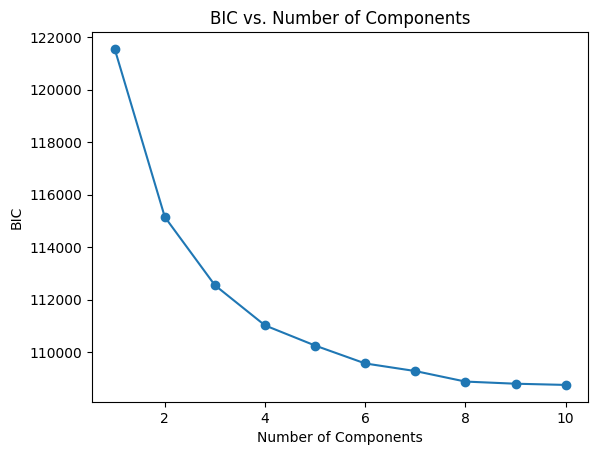

Optimal number of components: 10


In [9]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Example lottery numbers (replace with your actual data)
lottery_numbers = lottery_numbers

# Normalize the lottery numbers
lottery_numbers_normalized = (
    lottery_numbers - np.mean(lottery_numbers)) / np.std(lottery_numbers)

# Range of components to try
n_components_range = range(1, 11)
bics = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(lottery_numbers_normalized.reshape(-1, 1))
    bics.append(gmm.bic(lottery_numbers_normalized.reshape(-1, 1)))

# Plot BIC values
plt.plot(n_components_range, bics, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC')
plt.title('BIC vs. Number of Components')
plt.show()

# Select the optimal number of components
optimal_n_components = n_components_range[np.argmin(bics)]
print(f"Optimal number of components: {optimal_n_components}")

In [10]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Example lottery numbers (replace with your actual data)
lottery_numbers = lottery_numbers

# Optimal number of components found using BIC
optimal_n_components = 10

# Fit Gaussian Mixture Model to get initial parameters
gmm = GaussianMixture(n_components=optimal_n_components, random_state=42)
gmm.fit(np.array(lottery_numbers).reshape(-1, 1))

# Extract initial parameters
mu = gmm.means_.flatten()
sigma = np.sqrt(gmm.covariances_).flatten()
pi = gmm.weights_

# Print initial parameters
print(f"Initial Means: {mu}")
print(f"Initial Standard Deviations: {sigma}")
print(f"Initial Mixing Coefficients: {pi}")

# Initialize parameters for EM algorithm
n_components = optimal_n_components
lambda_reg = 0.01

# Number of epochs and tolerance for convergence
num_epochs = 1000
log_likelihoods = []

for epoch in range(num_epochs):
    # E-step: Compute responsibilities
    gamma = np.zeros((len(lottery_numbers), n_components))
    for k in range(n_components):
        gamma[:, k] = pi[k] * norm.pdf(lottery_numbers, mu[k], sigma[k])
    gamma /= gamma.sum(axis=1, keepdims=True)

    # M-step: Update parameters
    for k in range(n_components):
        N_k = gamma[:, k].sum()
        mu[k] = (gamma[:, k] * lottery_numbers).sum() / N_k
        sigma[k] = np.sqrt(
            (gamma[:, k] * (lottery_numbers - mu[k])**2).sum() / N_k)
        pi[k] = N_k / len(lottery_numbers)

    # Compute log-likelihood
    log_likelihood = np.sum(np.log(np.sum(
        [pi[k] * norm.pdf(lottery_numbers, mu[k], sigma[k]) for k in range(n_components)], axis=0)))
    log_likelihood -= lambda_reg * (np.sum(mu**2) + np.sum(sigma**2))
    log_likelihoods.append(log_likelihood)


Initial Means: [ 3.61468229 80.78471013 38.44755762 20.1256692  58.63826699 92.86376362
 69.14763341 11.42736522 48.61949066 29.1509117 ]
Initial Standard Deviations: [2.55041765 4.57606406 3.79268819 3.51949192 3.85380044 4.15879367
 4.20668657 3.11299912 3.82113268 3.51990077]
Initial Mixing Coefficients: [0.07901101 0.12366817 0.10175204 0.09019365 0.10140093 0.12342928
 0.11183613 0.08235628 0.09967937 0.08667313]


### Plot log-likelihood

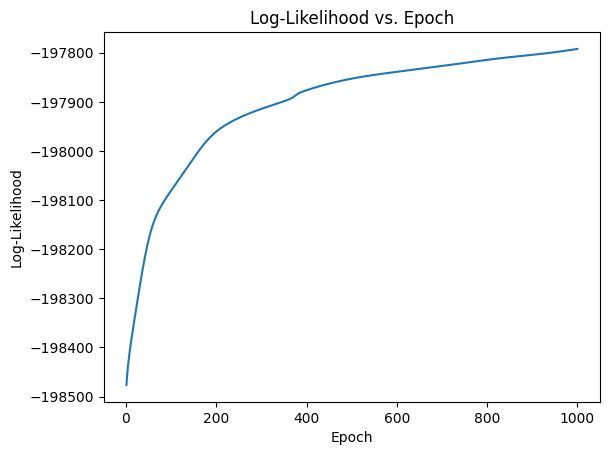

Final Log-Likelihood: -197792.26984786335


In [11]:
# Plot log-likelihood values over epochs
plt.plot(range(1, len(log_likelihoods) + 1), log_likelihoods)
plt.xlabel('Epoch')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs. Epoch')
plt.show()

print(f"Final Log-Likelihood: {log_likelihoods[-1]}")

### Plot Density Estimation of Lottery Numbers

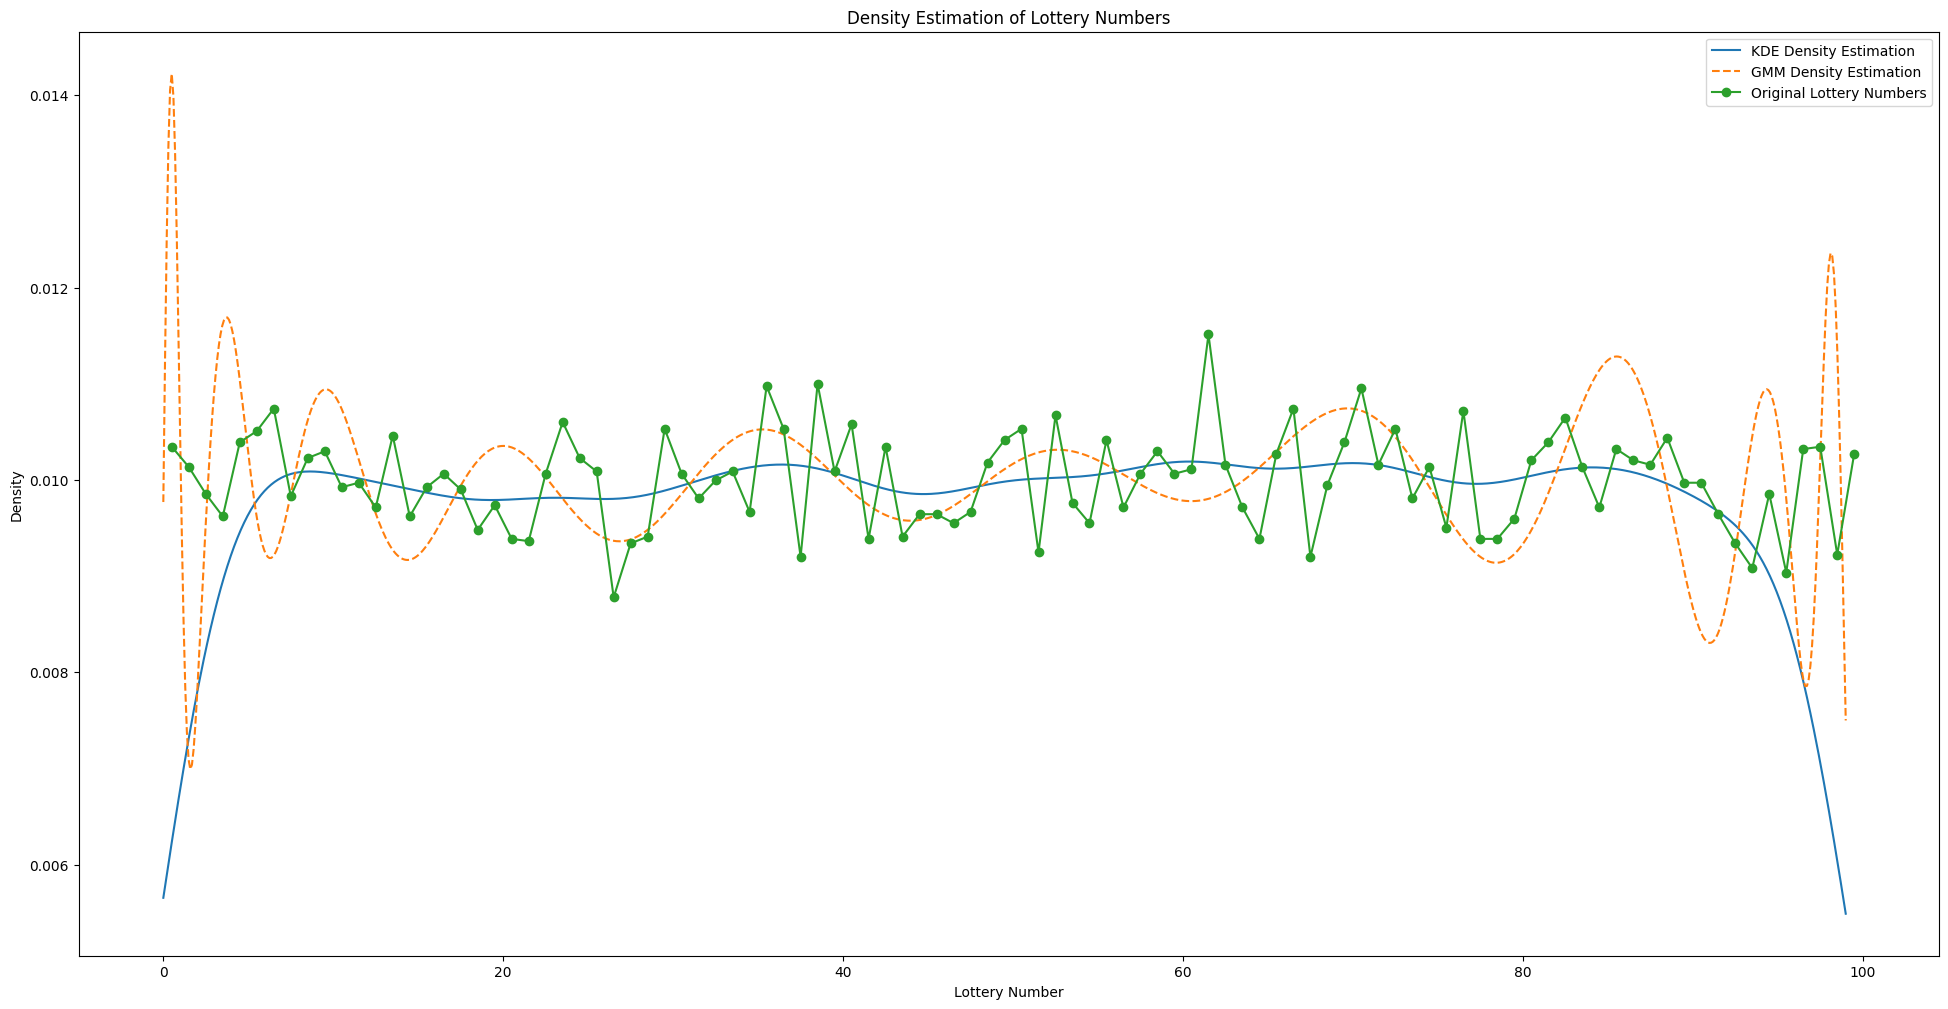

In [12]:
from scipy.stats import gaussian_kde

# Perform kernel density estimation
kde = gaussian_kde(lottery_numbers, bw_method='scott')

# Generate a range of values for plotting the density
lottery_numbers_range = np.linspace(0, 99, 1000)
density_estimation_kde = kde(lottery_numbers_range)

# Plot the KDE density estimation
plt.figure(figsize=(24, 12))  # Increase the figure size
plt.plot(lottery_numbers_range, density_estimation_kde, label='KDE Density Estimation')

# Plot the GMM density estimation
density_estimation_gmm = np.zeros_like(lottery_numbers_range)
for k in range(optimal_n_components):
    density_estimation_gmm += pi[k] * norm.pdf(lottery_numbers_range, mu[k], sigma[k])

plt.plot(lottery_numbers_range, density_estimation_gmm, label='GMM Density Estimation', linestyle='--')

# Plot the original lottery numbers as a line chart
frequency, bins = np.histogram(lottery_numbers, bins=range(101), density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, frequency, label='Original Lottery Numbers', linestyle='-', marker='o')

plt.xlabel('Lottery Number')
plt.ylabel('Density')
plt.title('Density Estimation of Lottery Numbers')
plt.legend()
plt.show()